In [322]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('data/nyc-rolling-sales.csv')
df.columns

Index(['Unnamed: 0', 'BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING CLASS AT PRESENT', 'ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE',
       'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS',
       'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE',
       'SALE PRICE', 'SALE DATE'],
      dtype='object')

* Borough: The name of the borough in which the property is located.
* Neighborhood: The common name of the neighborhood
* Building Class Category: This is a field that we are including so that users of the Rolling Sales Files can easily identify similar properties by broad usage (e.g. One Family Homes) without looking up individual Building Classes.
* Tax Class at Present: Every property in the city is assigned to one of four tax classes (Classes 1, 2, 3, and 4), based on the use of the property.
* Block: A Tax Block is a sub-division of the borough on which real properties are located.
* Lot: A Tax Lot is a subdivision of a Tax Block and represents the property unique location.
* Easement: An easement is a right, such as a right of way, which allows an entity to make limited use of another’s real property. For example: MTA railroad tracks that run across a portion of another property.
* Building Class at Present: The Building Classification is used to describe a property’s constructive use.
* Address: The street address of the property as listed on the Sales File.
* Zip Code: The property’s postal code
* Residential Units: The number of residential units at the listed property.
* Commercial Units: The number of commercial units at the listed property.
* Total Units: The total number of units at the listed property.
* Land Square Feet: The land area of the property listed in square feet.
* Gross Square Feet: The total area of all the floors of a building as measured from the exterior surfaces of the outside walls of the building, including the land area and space within any building or structure on the property.
* Year Built: Year the structure on the property was built.
* Building Class at Time of Sale: The Building Classification is used to describe a property’s constructive use.
* Sales Price: Price paid for the property.
* Sale Date: Date the property sold.

In [323]:
df.describe()

,Unnamed: 0,BOROUGH,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,YEAR BUILT,TAX CLASS AT TIME OF SALE
count,84548.000000,84548.000000,84548.000000,84548.000000,84548.000000,84548.000000,84548.000000,84548.000000,84548.000000,84548.000000
mean,10344.359878,2.998758,4237.218976,376.224015,10731.991614,2.025264,0.193559,2.249184,1789.322976,1.657485
std,7151.779436,1.289790,3568.263407,658.136814,1290.879147,16.721037,8.713183,18.972584,537.344993,0.819341
min,4.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4231.000000,2.000000,1322.750000,22.000000,10305.000000,0.000000,0.000000,1.000000,1920.000000,1.000000
50%,8942.000000,3.000000,3311.000000,50.000000,11209.000000,1.000000,0.000000,1.000000,1940.000000,2.000000
75%,15987.250000,4.000000,6281.000000,1001.000000,11357.000000,2.000000,0.000000,2.000000,1965.000000,2.000000
max,26739.000000,5.000000,16322.000000,9106.000000,11694.000000,1844.000000,2261.000000,2261.000000,2017.000000,4.000000


In [324]:
class NYCSalesPreprocessor:
    def __init__(self, filepath):
        self.df = pd.read_csv(filepath)
    def drop_columns(self, columns):
        self.df.drop(columns=columns, inplace=True)
    def convert_to_numeric(self, columns):
        for col in columns:
            self.df[col] = pd.to_numeric(self.df[col], errors='coerce')
    def convert_to_datetime(self, columns):
        for col in columns:
            self.df[col] = pd.to_datetime(self.df[col], errors='coerce')
    def replace_with(self, column, value_to_replace,value):
        self.df[column].replace(value_to_replace, value, inplace=True)
    def fill_missing_values(self, columns, method='median'):
        for col in columns:
            if method == 'median':
                self.df[col].fillna(self.df[col].median(), inplace=True)
            elif method == 'mean':
                self.df[col].fillna(self.df[col].mean(), inplace=True)
            elif method == 'mode':
                self.df[col].fillna(self.df[col].mode()[0], inplace=True)  
    def drop_missing_values(self, subset_columns):
        self.df.dropna(subset=subset_columns, inplace=True)
    def convert_to_categorical(self, columns):
        for col in columns:
            self.df[col] = self.df[col].astype('category')
    def map_values(self, column, mapping_dict):
        self.df[column] = self.df[column].map(mapping_dict)
        #self.df[column].replace(mapping_dict, inplace=True)
    def extract_datetime_features(self, datetime_column, features):
        for feature in features:
            if feature == 'year':
                self.df[f'{datetime_column}_year'] = self.df[datetime_column].dt.year
            elif feature == 'month':
                self.df[f'{datetime_column}_month'] = self.df[datetime_column].dt.month
            elif feature == 'day':
                self.df[f'{datetime_column}_day'] = self.df[datetime_column].dt.day
    def remove_outliers(self, column, threshold, condition='greater_than'):
        if condition == 'greater_than':
            self.df = self.df[self.df[column] > threshold]
        elif condition == 'less_than':
            self.df = self.df[self.df[column] < threshold]
        else:
            raise ValueError("Invalid condition. Use 'greater_than' or 'less_than'.")
    def rename_columns(self):
        self.df.rename(columns=lambda x: x.strip().replace(' ', '_').lower(), inplace=True)
    def preprocess(self):
        self.drop_columns(['Unnamed: 0'])
        self.convert_to_numeric(['SALE PRICE', 'LAND SQUARE FEET', 'GROSS SQUARE FEET'])
        self.convert_to_datetime(['SALE DATE'])
        self.replace_with('SALE PRICE', '-',np.nan)
        self.replace_with('SALE PRICE', '',np.nan)
        self.drop_missing_values(['SALE PRICE'])
        self.fill_missing_values(['LAND SQUARE FEET', 'GROSS SQUARE FEET'], method='median')
        #self.convert_to_categorical(['NEIGHBORHOOD', 'BUILDING CLASS CATEGORY', 'TAX CLASS AT PRESENT', 
                                     #'BUILDING CLASS AT PRESENT', 'BUILDING CLASS AT TIME OF SALE'])
        borough_mapping = {1: 'Manhattan', 2: 'Bronx', 3: 'Brooklyn', 4: 'Queens', 5: 'Staten Island'}
        self.map_values('BOROUGH', borough_mapping)
        self.extract_datetime_features('SALE DATE', ['year', 'month'])
        #self.remove_outliers('SALE PRICE', 500000000, condition='less_than')
        #self.remove_outliers('SALE PRICE', 50000, condition='greater_than')
        self.rename_columns()
    
    def save_cleaned_data(self, output_path):
        self.df.to_csv(output_path, index=False)
    def get_cleaned_data(self):
        return self.df
preprocessor = NYCSalesPreprocessor('data/nyc-rolling-sales.csv')
preprocessor.preprocess()
df = preprocessor.get_cleaned_data()

In [325]:
df.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
block,69987.0,4196.072528,1.0,1348.0,3378.0,6186.0,16319.0,3429.196524
lot,69987.0,373.828397,1.0,22.0,50.0,709.0,9106.0,656.096528
zip_code,69987.0,10741.455185,0.0,10306.0,11209.0,11249.0,11694.0,1263.234938
residential_units,69987.0,1.899553,0.0,0.0,1.0,2.0,1844.0,14.549545
commercial_units,69987.0,0.172489,0.0,0.0,0.0,0.0,2261.0,9.123717
total_units,69987.0,2.092203,0.0,0.0,1.0,2.0,2261.0,17.2761
land_square_feet,69987.0,3181.520197,0.0,1900.0,2150.0,2504.0,4252327.0,33706.348399
gross_square_feet,69987.0,3034.999086,0.0,1268.0,1620.0,2068.0,3750565.0,24491.539985
year_built,69987.0,1799.348236,0.0,1920.0,1937.0,1965.0,2017.0,520.884552
tax_class_at_time_of_sale,69987.0,1.641976,1.0,1.0,2.0,2.0,4.0,0.771162


Sale Price minimum value is 0 so problematic for tha data. It is because of free transaction of the property.

<Axes: xlabel='sale_price', ylabel='Count'>

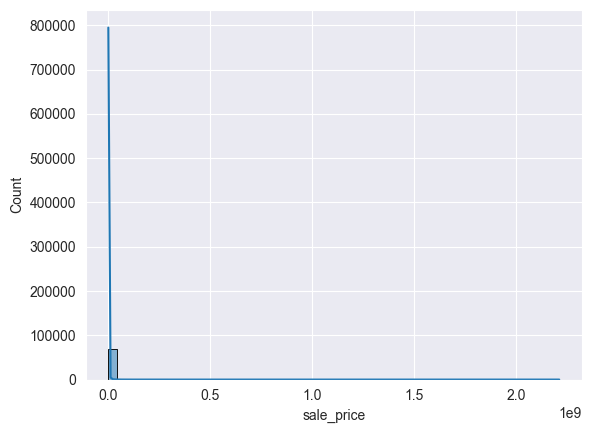

In [326]:
import seaborn  as sns
sns.histplot(df['sale_price'], bins=50,edgecolor = "k", kde=True)

Very problematic target variable distribution, should be close to normal distribution and/or acceptable skewness.

<Axes: xlabel='sale_price', ylabel='Count'>

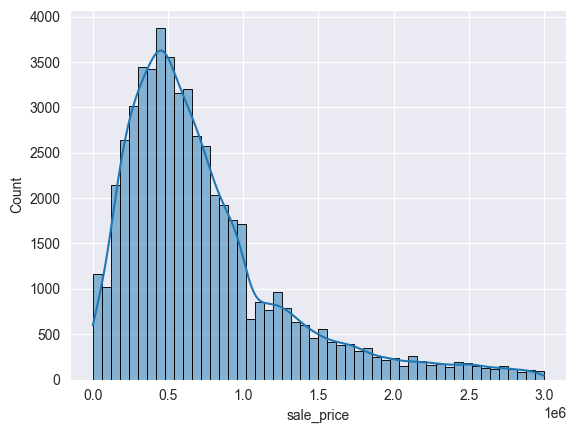

In [327]:
data = df.copy() # store initial data
df = df[(df['sale_price'] < 3000000)& (df['sale_price']>10)] # remove some outliers
sns.histplot(df['sale_price'], bins=50,edgecolor = "k", kde=True)

When we extract  price below 10 and price above 500000 looks acceptable.

In [328]:
df['sale_price'].skew()

1.5567116059117692

<Axes: xlabel='year_built', ylabel='sale_price'>

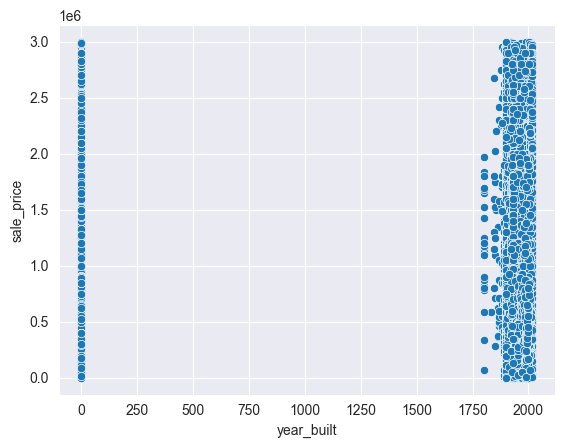

In [329]:
sns.scatterplot(x=df['year_built'], y=df['sale_price'])


Year built has some outliers and/or non-meaningfull values.

Text(0.5, 1.0, "Borough by property's sales amount")

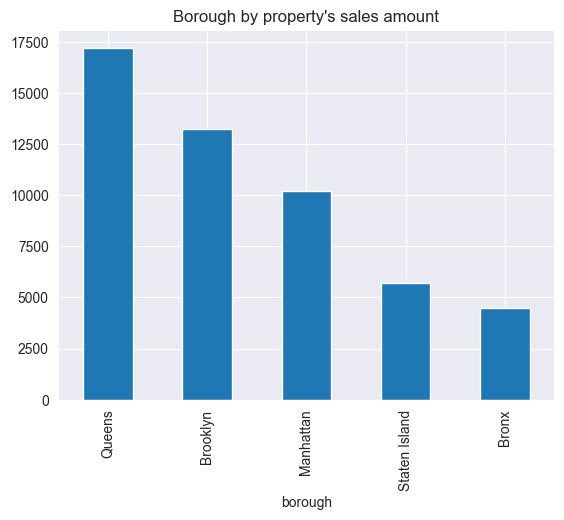

In [330]:
df = df[df['year_built'] > 1500] # remove some outliers
#df.loc[:, 'age'] = 2024 - df['year_built']
df['borough'].value_counts().plot.bar()
plt.title("Borough by property's sales amount")

Text(0.5, 1.0, "Borough by property's average sales")

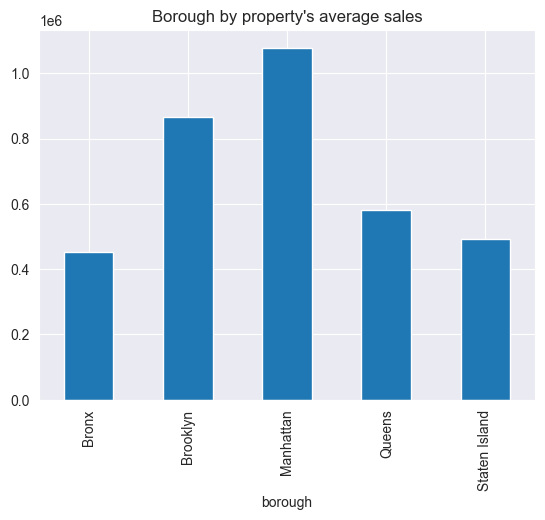

In [331]:
df['sale_price'].groupby(df['borough']).mean().plot.bar()
plt.title("Borough by property's average sales")

Text(0.5, 1.0, "Borough property's transaction amount")

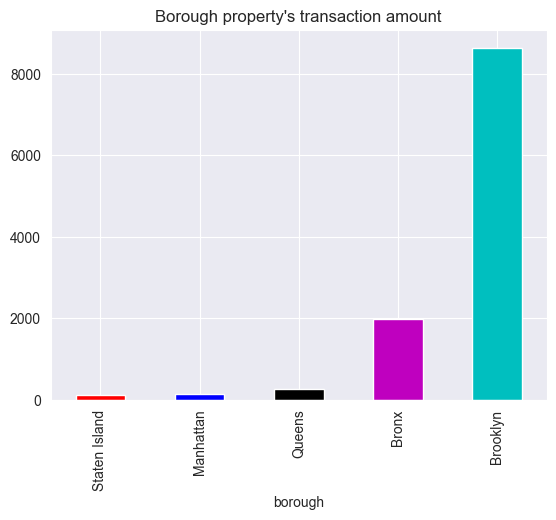

In [332]:
data[data['sale_price'] <= 10]['borough'].value_counts().sort_values().plot.bar(color=['r', 'b', 'k', 'm', 'c'])
plt.title("Borough property's transaction amount")

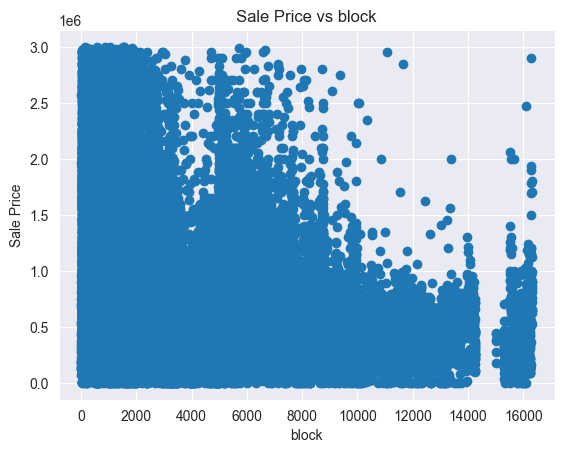

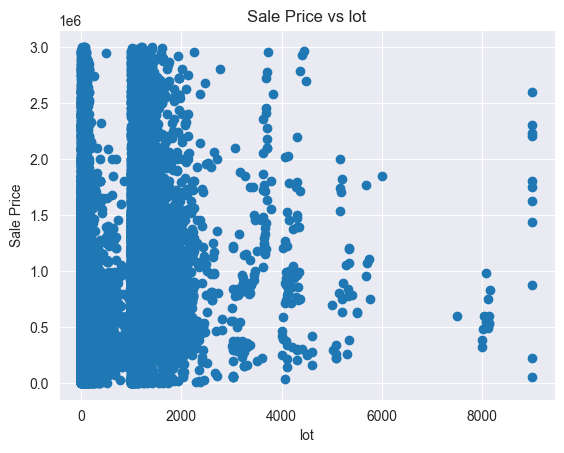

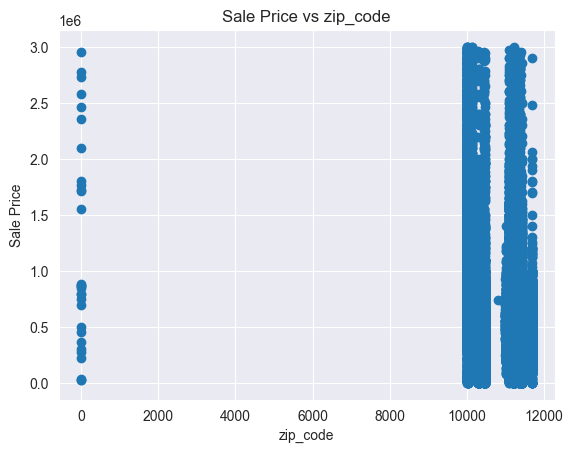

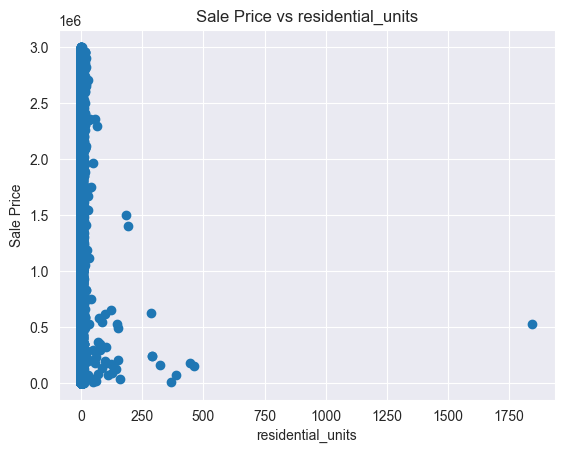

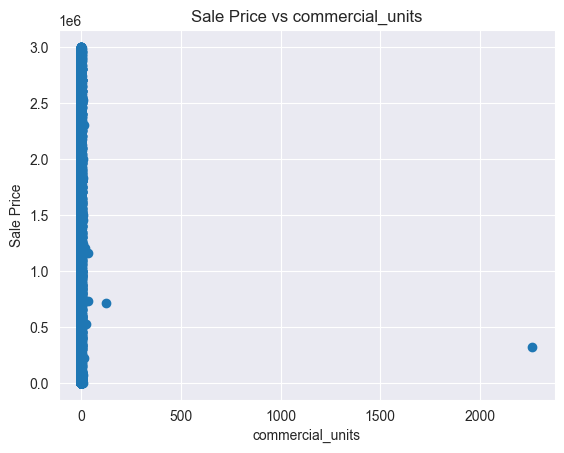

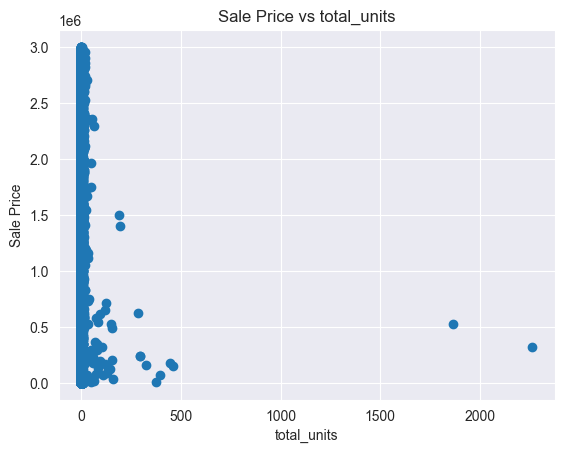

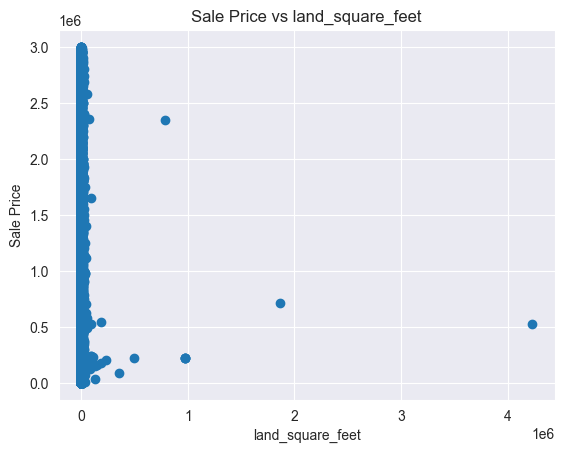

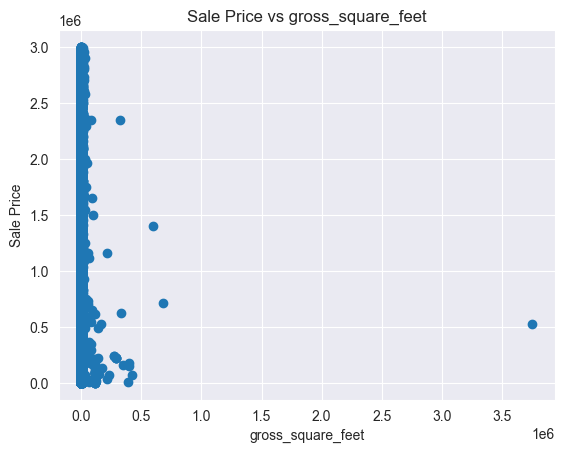

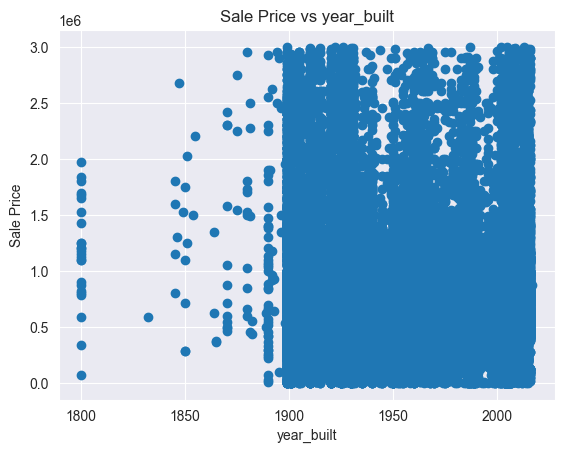

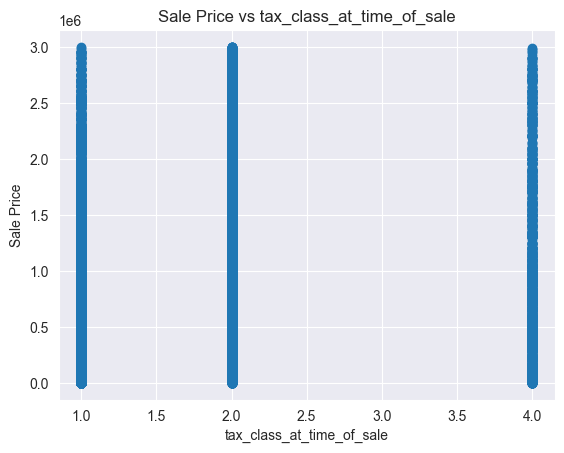

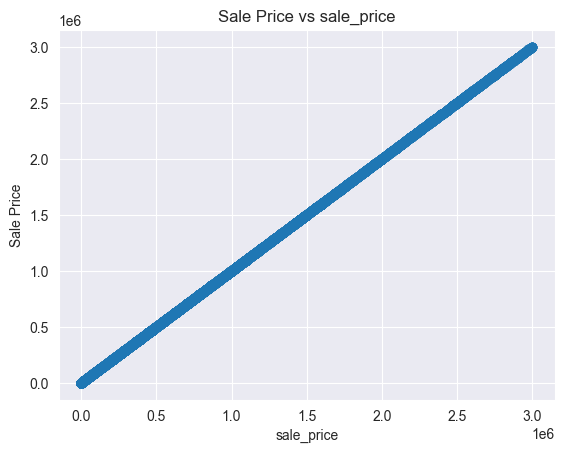

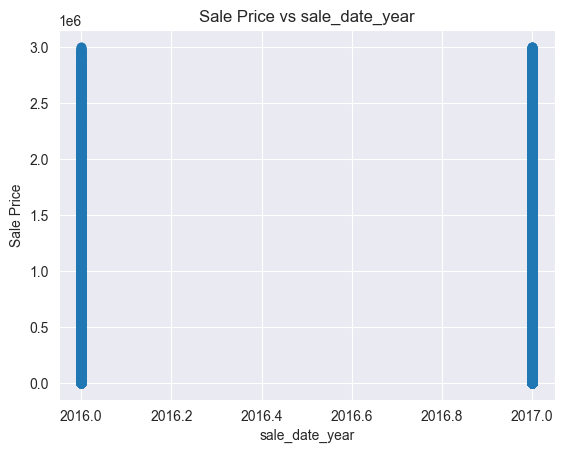

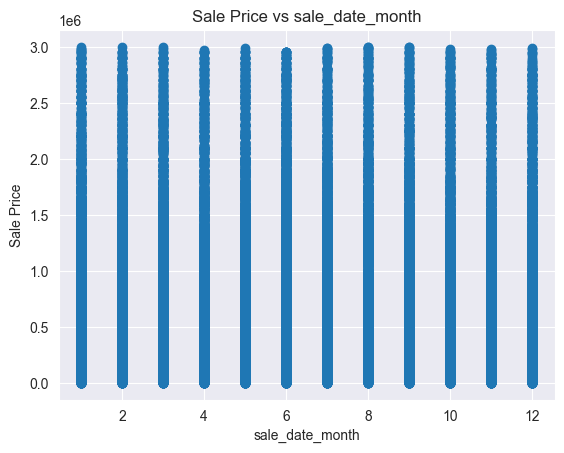

In [333]:
numeric_columns = df.select_dtypes(include=[np.number]).columns
for i in numeric_columns:
    plt.figsize=(5, 5)
    plt.scatter(df[i], df['sale_price'])
    plt.xlabel(i)
    plt.ylabel('Sale Price')
    plt.title(f'Sale Price vs {i}')
    plt.show()

Comments: no strong linear relationship with variable vs sale price.

In [334]:
categorical_columns = df.select_dtypes(include=['category','object']).columns
categorical_columns

Index(['borough', 'neighborhood', 'building_class_category',
       'tax_class_at_present', 'ease-ment', 'building_class_at_present',
       'address', 'apartment_number', 'building_class_at_time_of_sale'],
      dtype='object')

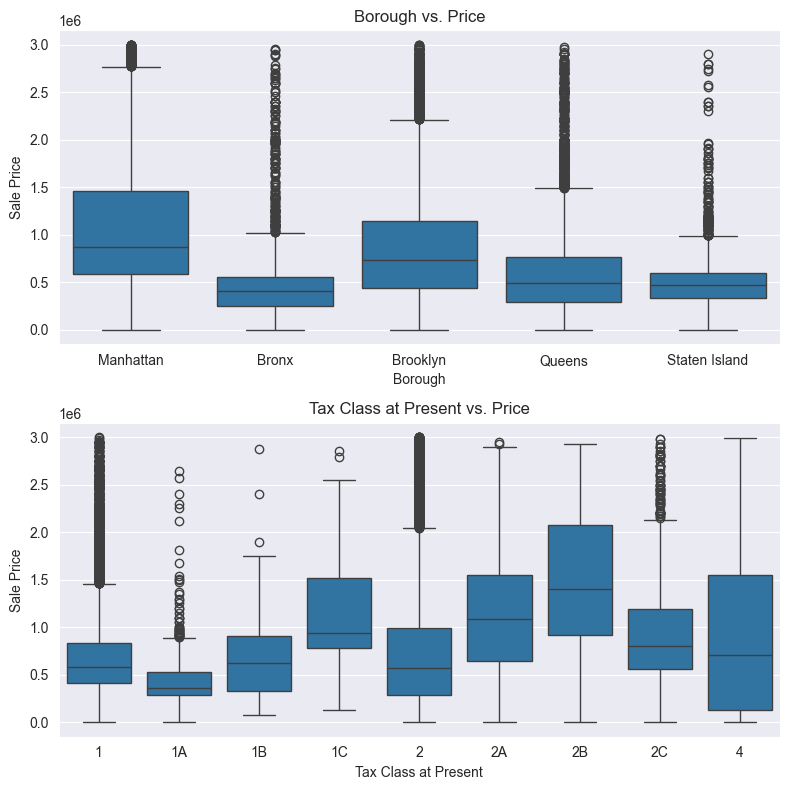

In [335]:
sns.set_style('darkgrid')
f, axes = plt.subplots(2, 1, figsize=(8, 8))

order_tax = sorted(df['tax_class_at_present'].unique())
order_class = sorted(df['building_class_category'].unique())

# Plot of borough vs. sale price
sns.boxplot(x='borough', y='sale_price', data=df, ax=axes[0])
axes[0].set_xlabel('Borough')
axes[0].set_ylabel('Sale Price')
axes[0].set_title('Borough vs. Price')

# Plot of tax class at present vs. sale price
sns.boxplot(x='tax_class_at_present', y='sale_price', data=df, ax=axes[1], order=order_tax)
axes[1].set_xlabel('Tax Class at Present')
axes[1].set_ylabel('Sale Price')
axes[1].set_title('Tax Class at Present vs. Price')

plt.tight_layout()
plt.show()
    

In [336]:
from collections import Counter
#neighborhood = list(dict(Counter(new_housing.neighborhood).most_common(20)).keys())
neighborhood = list(dict(Counter(df.neighborhood).most_common(20)).keys())

avg_sale_prices = []
for i in neighborhood:
    avg_price = np.mean(df.sale_price[df.neighborhood == i])
    avg_sale_prices.append(avg_price)

Text(0.5, 1.0, 'Average Property Price in the Top 20 Neighborhoods')

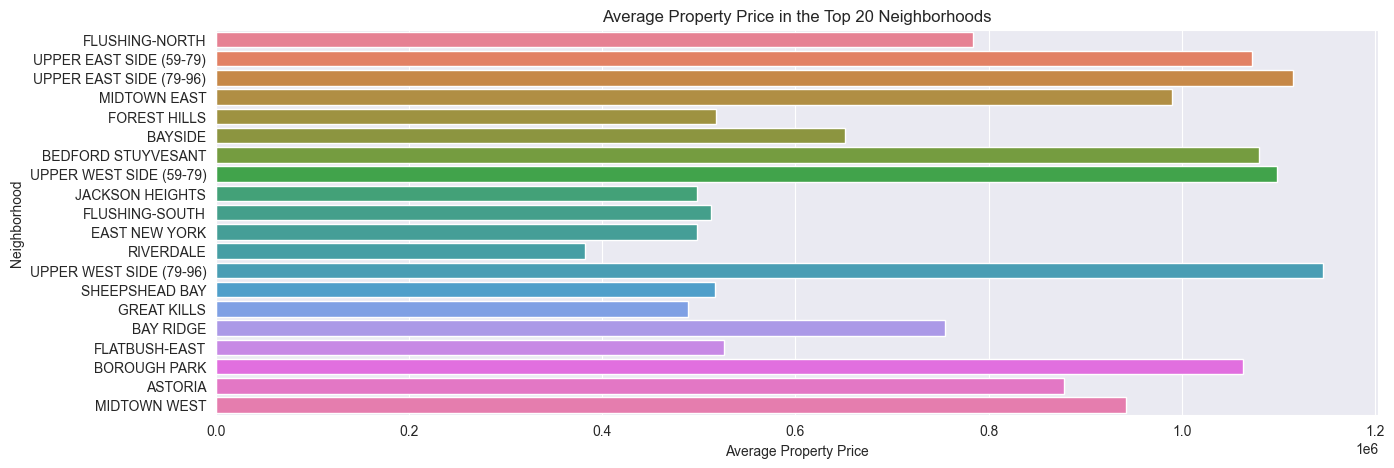

In [337]:
#most expensive neighborhoods with highest average property price
plt.figure(figsize=(15,5))

ax = sns.barplot(x= avg_sale_prices, y= neighborhood ,legend=False, hue = neighborhood)
ax.set_xlabel('Average Property Price')
ax.set_ylabel('Neighborhood')
plt.title('Average Property Price in the Top 20 Neighborhoods')

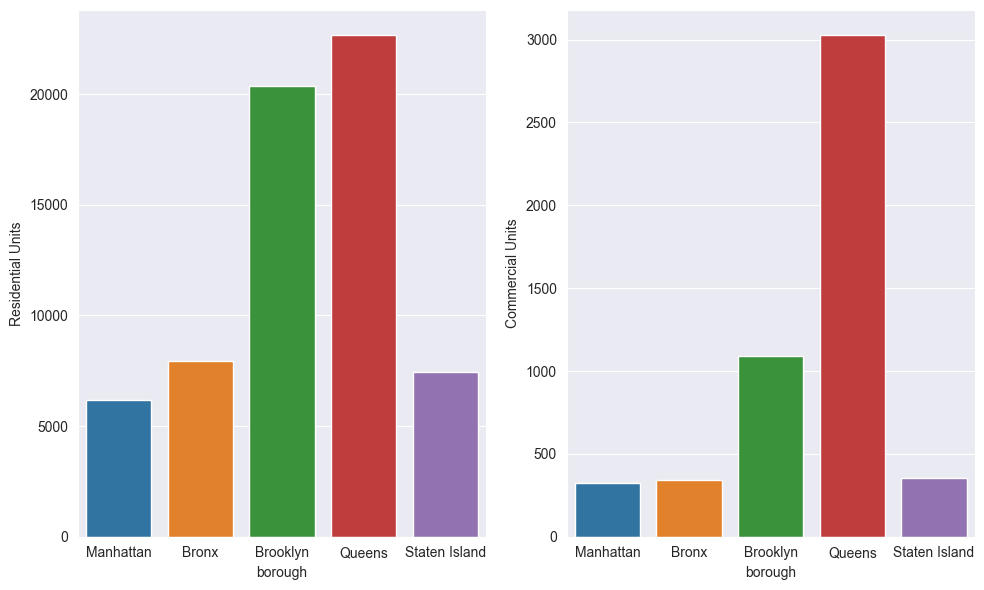

In [338]:
plt.figure(figsize=(10,6))

plt.subplot(1, 2, 1)
sns.barplot(x="borough", y="residential_units", data=df, estimator=sum, errorbar=None, hue = 'borough', legend=False)
plt.ylabel('Residential Units')
plt.subplot(1, 2, 2)
sns.barplot(x="borough", y="commercial_units", data=df, estimator=sum, errorbar=None, hue='borough', legend=False)
plt.ylabel('Commercial Units')

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Sale Price')

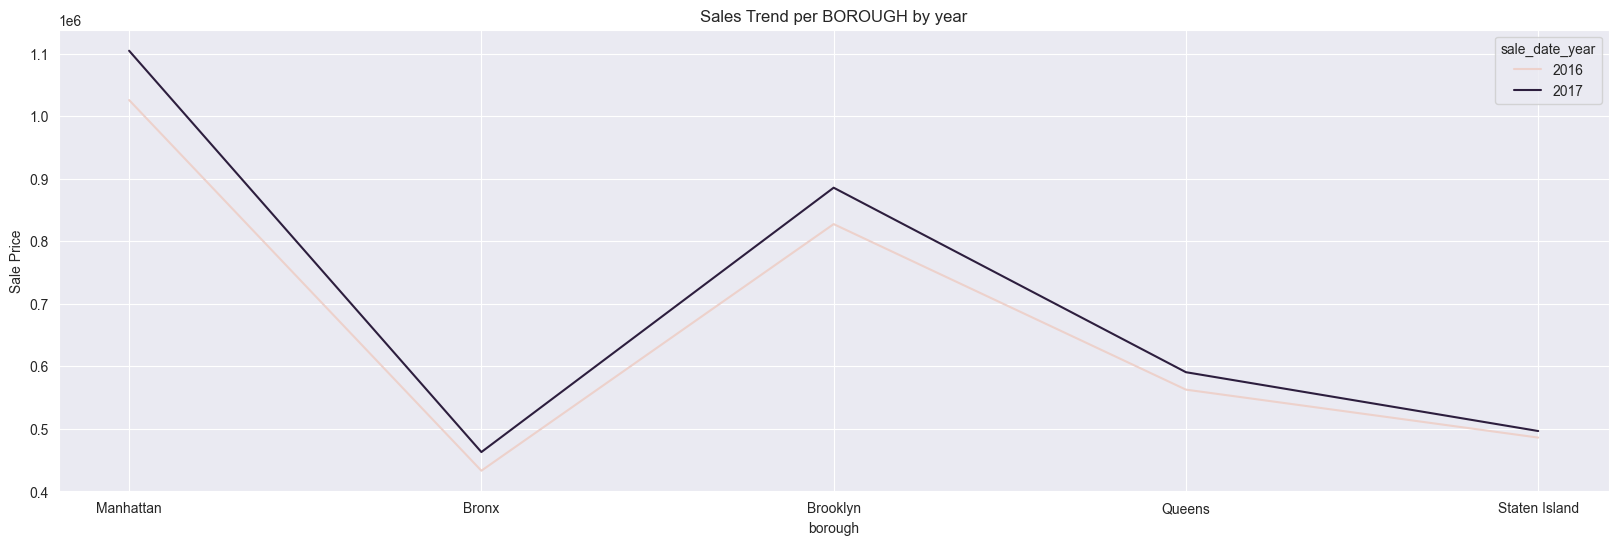

In [339]:
plt.figure(figsize=(20,6))

sns.lineplot(x="borough",y="sale_price",data=df, hue='sale_date_year',errorbar=None)
plt.title('Sales Trend per BOROUGH by year');
plt.ylabel('Sale Price')

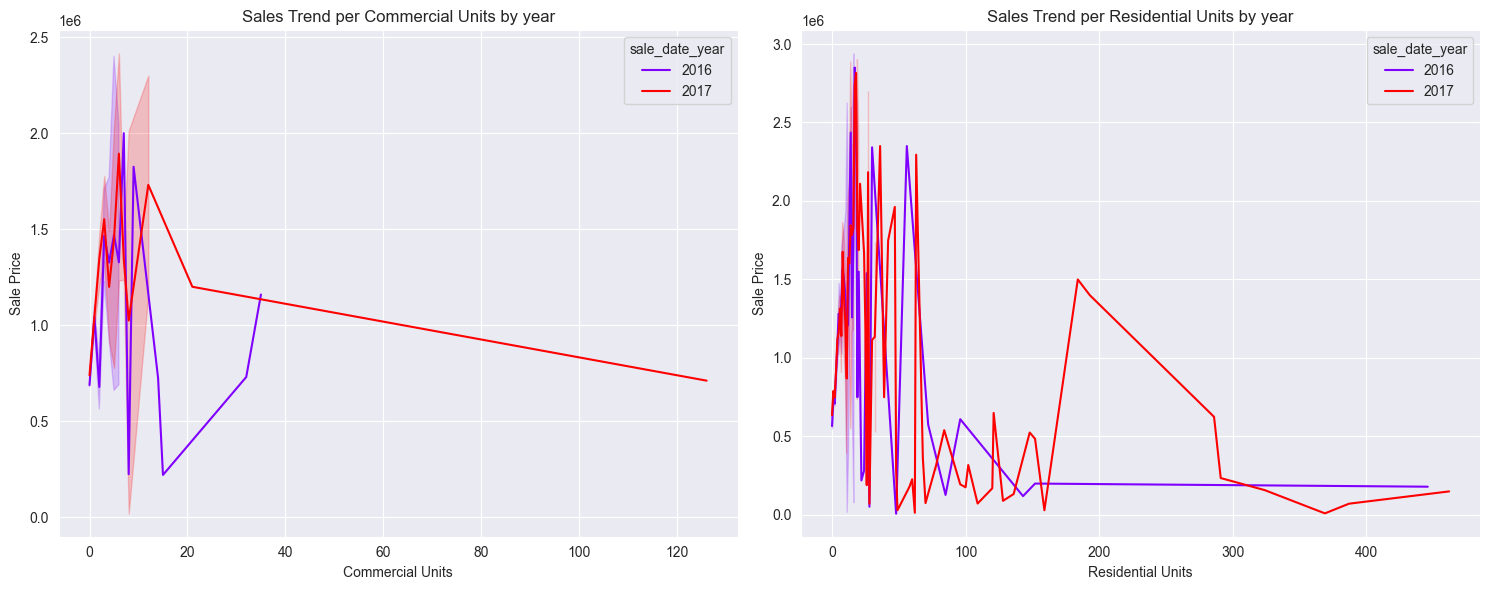

In [340]:
# Remove some outliers for commercial_units and residential_units
data_2 = df[(df['commercial_units'] < 500) & (df['residential_units'] < 500)]
f, axes = plt.subplots(1, 2, figsize=(15, 6))
# to remove some outliers                    ]
# Plot Sales Trend per Commercial Units by year
axes[0].set_title('Sales Trend per Commercial Units by year')
sns.lineplot(x="commercial_units", y="sale_price", hue='sale_date_year', data=data_2, palette='rainbow', ax=axes[0])
axes[0].set_ylabel('Sale Price')
axes[0].set_xlabel('Commercial Units')

# Plot Sales Trend per Residential Units by year
axes[1].set_title('Sales Trend per Residential Units by year')
sns.lineplot(x="residential_units", y="sale_price", hue='sale_date_year', data=data_2, palette='rainbow', ax=axes[1])
axes[1].set_ylabel('Sale Price')
axes[1].set_xlabel('Residential Units')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'average sales price per propertys usage of buildings')

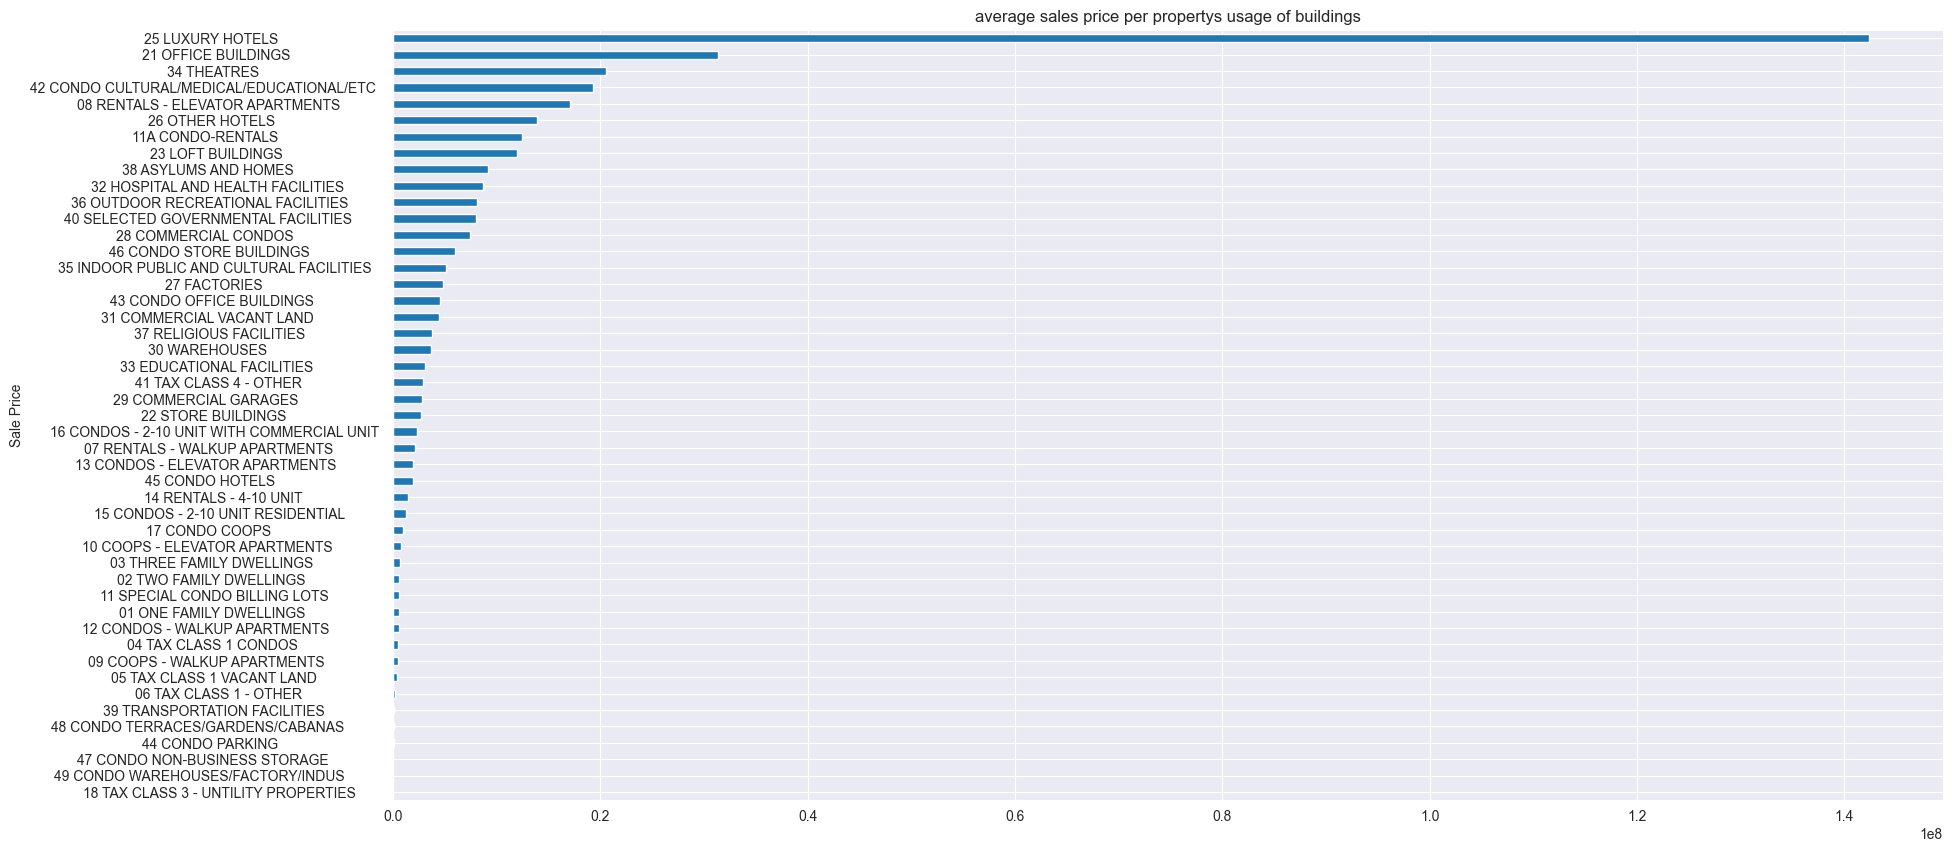

In [341]:
plt.figure(figsize=(20,10))

#new_housing['sale_price'].groupby(new_housing['building_class_category']).mean().sort_values().plot.barh()
#new_housing.groupby('building_class_category')['sale_price'].mean().sort_values()#.plot.barh()
data['sale_price'].groupby(data['building_class_category']).mean().sort_values().plot.barh()
plt.ylabel("Sale Price")

plt.title('average sales price per propertys usage of buildings')

Luxury hot the highest as expected. The raw data that not extracted outliers, since sale price outliers related to highest priced properties.

Text(0, 0.5, 'Sale Price')

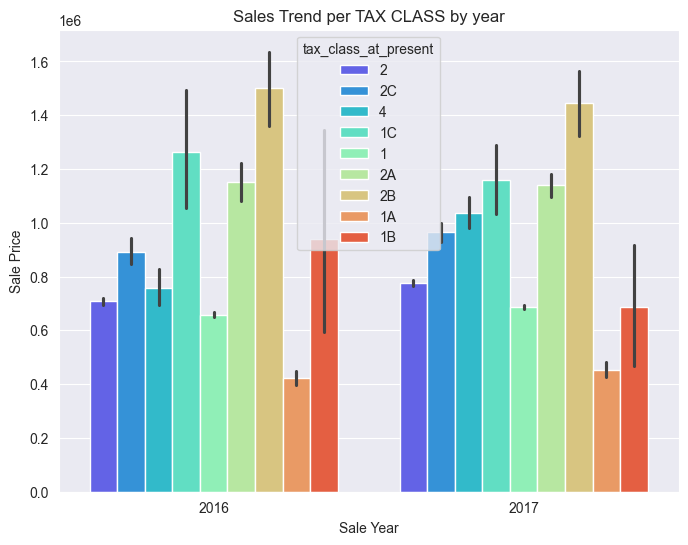

In [342]:
plt.figure(figsize=(8,6))
plt.title('Sales Trend per TAX CLASS by year')

sns.barplot(x="sale_date_year",y="sale_price",hue='tax_class_at_present',data=df[df['tax_class_at_present']!= ' '], palette='rainbow');
plt.xlabel('Sale Year')
plt.ylabel('Sale Price')

In [343]:
new_housing = df[(df['sale_price'] <3000000) #limit $5,000,000 
                       & (df['sale_price'] > 1000)
                       & (df['residential_units'] < 500) #limit up to 500 units
                       & (df['commercial_units'] < 500) #limit up to 500 units
                       & (df['gross_square_feet'] < 800000) 
                       ]
new_housing.to_csv('data/nyc_rolling_sales_cleaned_final.csv', index=False)

<Axes: xlabel='sale_price', ylabel='Count'>

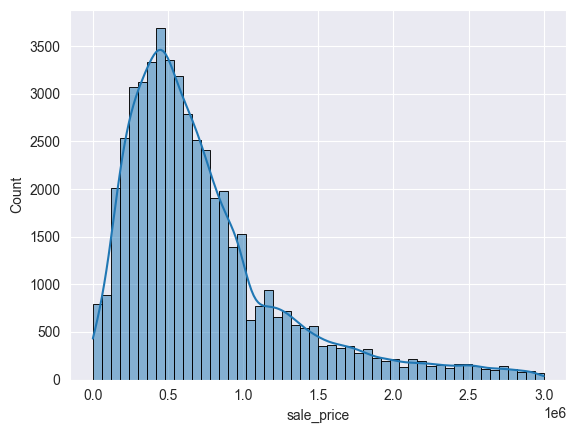

In [344]:
sns.histplot(new_housing['sale_price'], bins=50,edgecolor = "k", kde=True)

<Axes: >

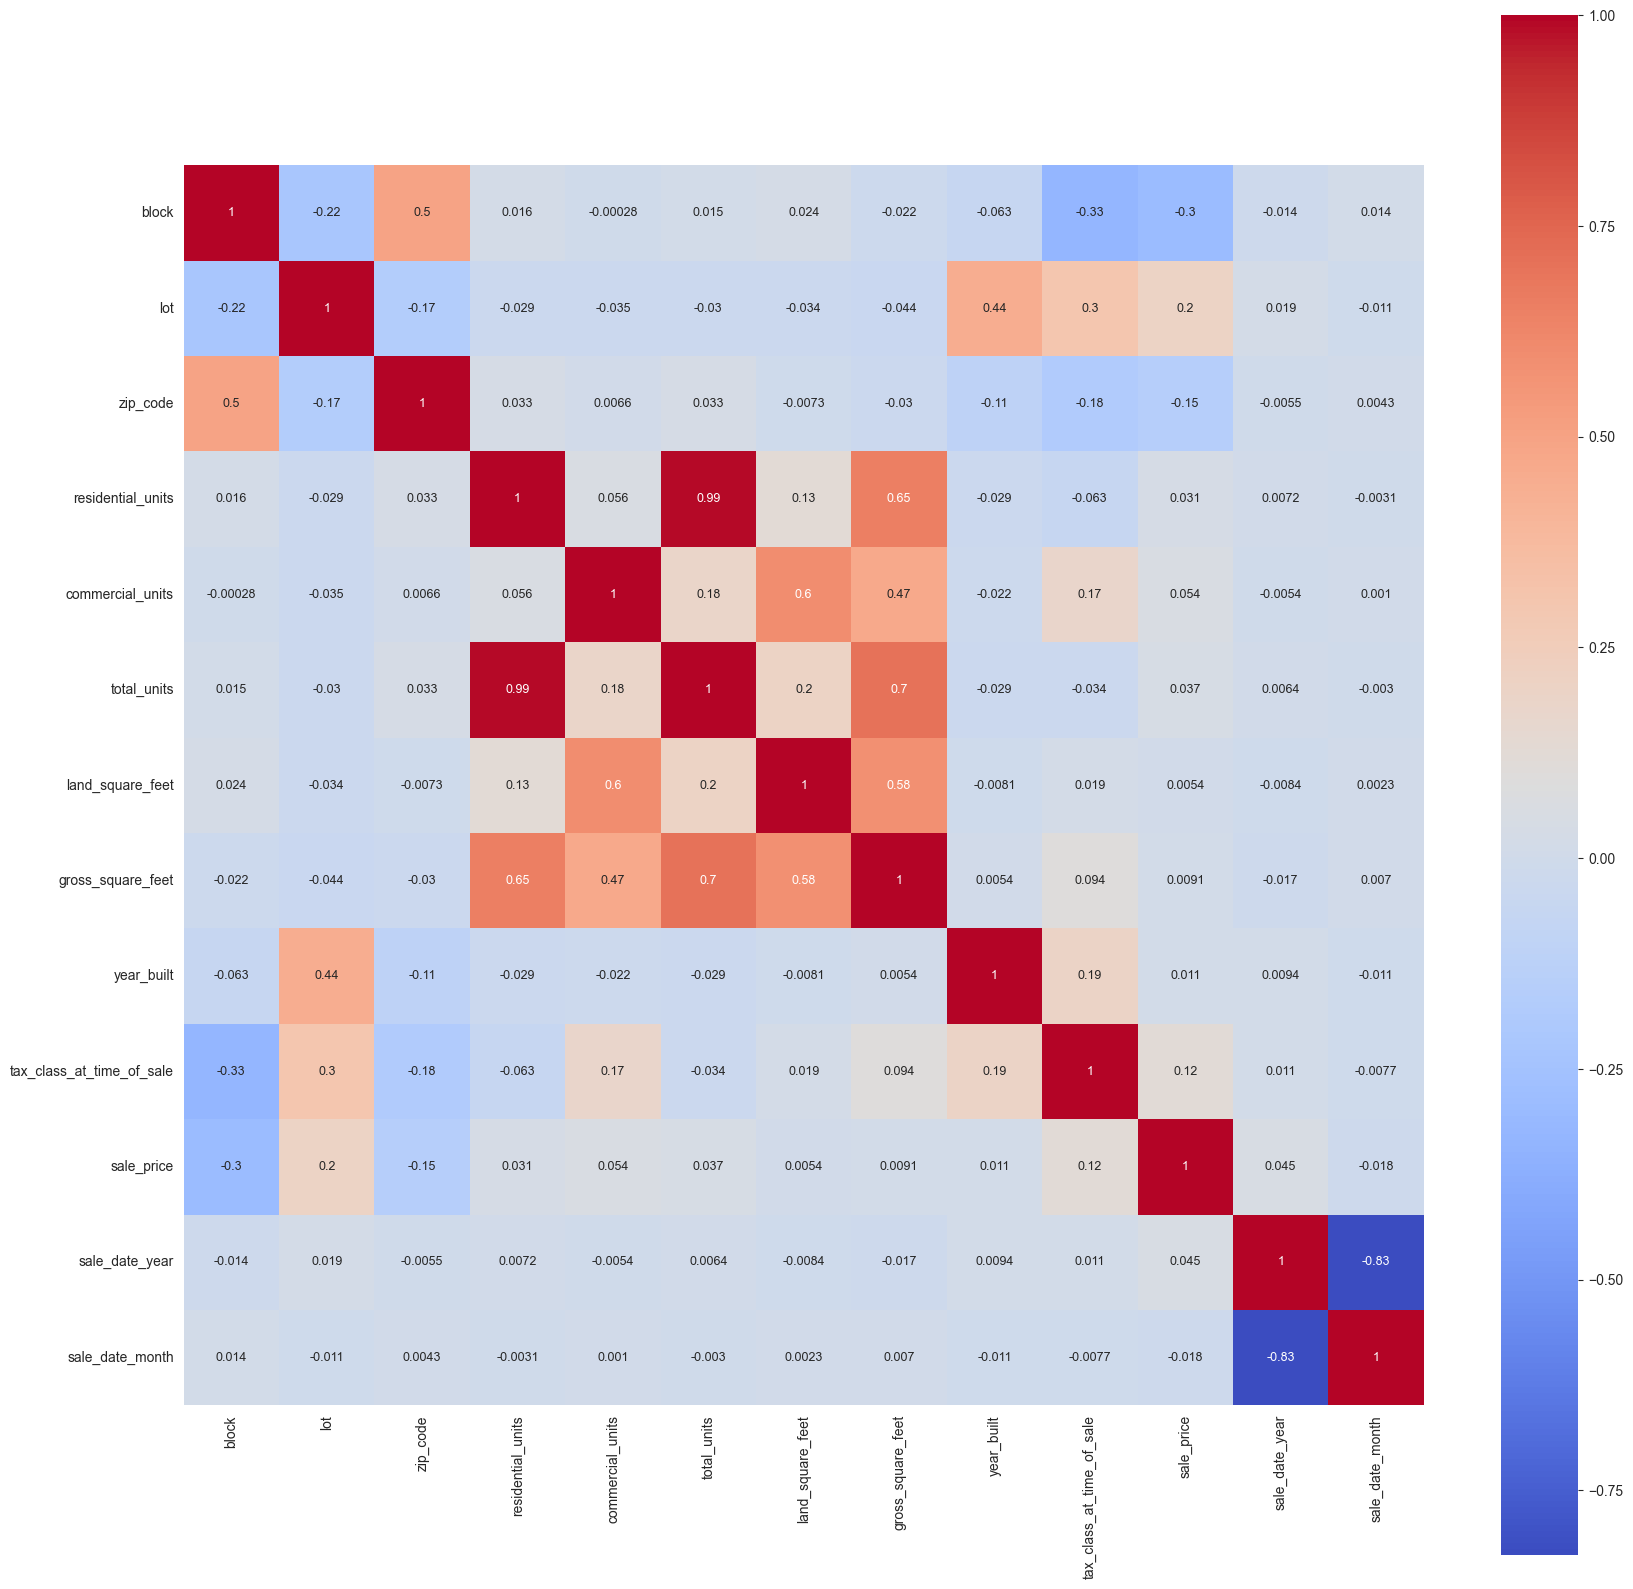

In [345]:
numeric_columns = new_housing.select_dtypes(include=[np.number]).columns
numeric_data = new_housing[numeric_columns]
numeric_corr = numeric_data.corr()
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(numeric_corr, cmap='coolwarm', square=True, annot=True, annot_kws={"size": 9})


In [346]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
# Initialize the label encoder
label_encoder = LabelEncoder()

# Apply label encoding to each categorical column
for column in categorical_columns:
    new_housing.loc[:,column] = label_encoder.fit_transform(new_housing[column])
new_housing.apply(pd.to_numeric, errors='coerce')
numeric_columns = new_housing.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()
# Apply standard scaling to the numeric columns
new_housing.loc[:,numeric_columns] = scaler.fit_transform(new_housing[numeric_columns])
'''new_housing_corr = new_housing.corr()
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(new_housing_corr, annot=True, cmap='coolwarm', fmt=".2f", ax=ax)
sns.heatmap(new_housing_corr, cmap='coolwarm', square=True, annot=True, annot_kws={"size": 9})
plt.title('Variable Correlation')'''

'new_housing_corr = new_housing.corr()\nf, ax = plt.subplots(figsize=(20, 20))\nsns.heatmap(new_housing_corr, annot=True, cmap=\'coolwarm\', fmt=".2f", ax=ax)\nsns.heatmap(new_housing_corr, cmap=\'coolwarm\', square=True, annot=True, annot_kws={"size": 9})\nplt.title(\'Variable Correlation\')'

Text(0.5, 1.0, 'Variable Correlation')

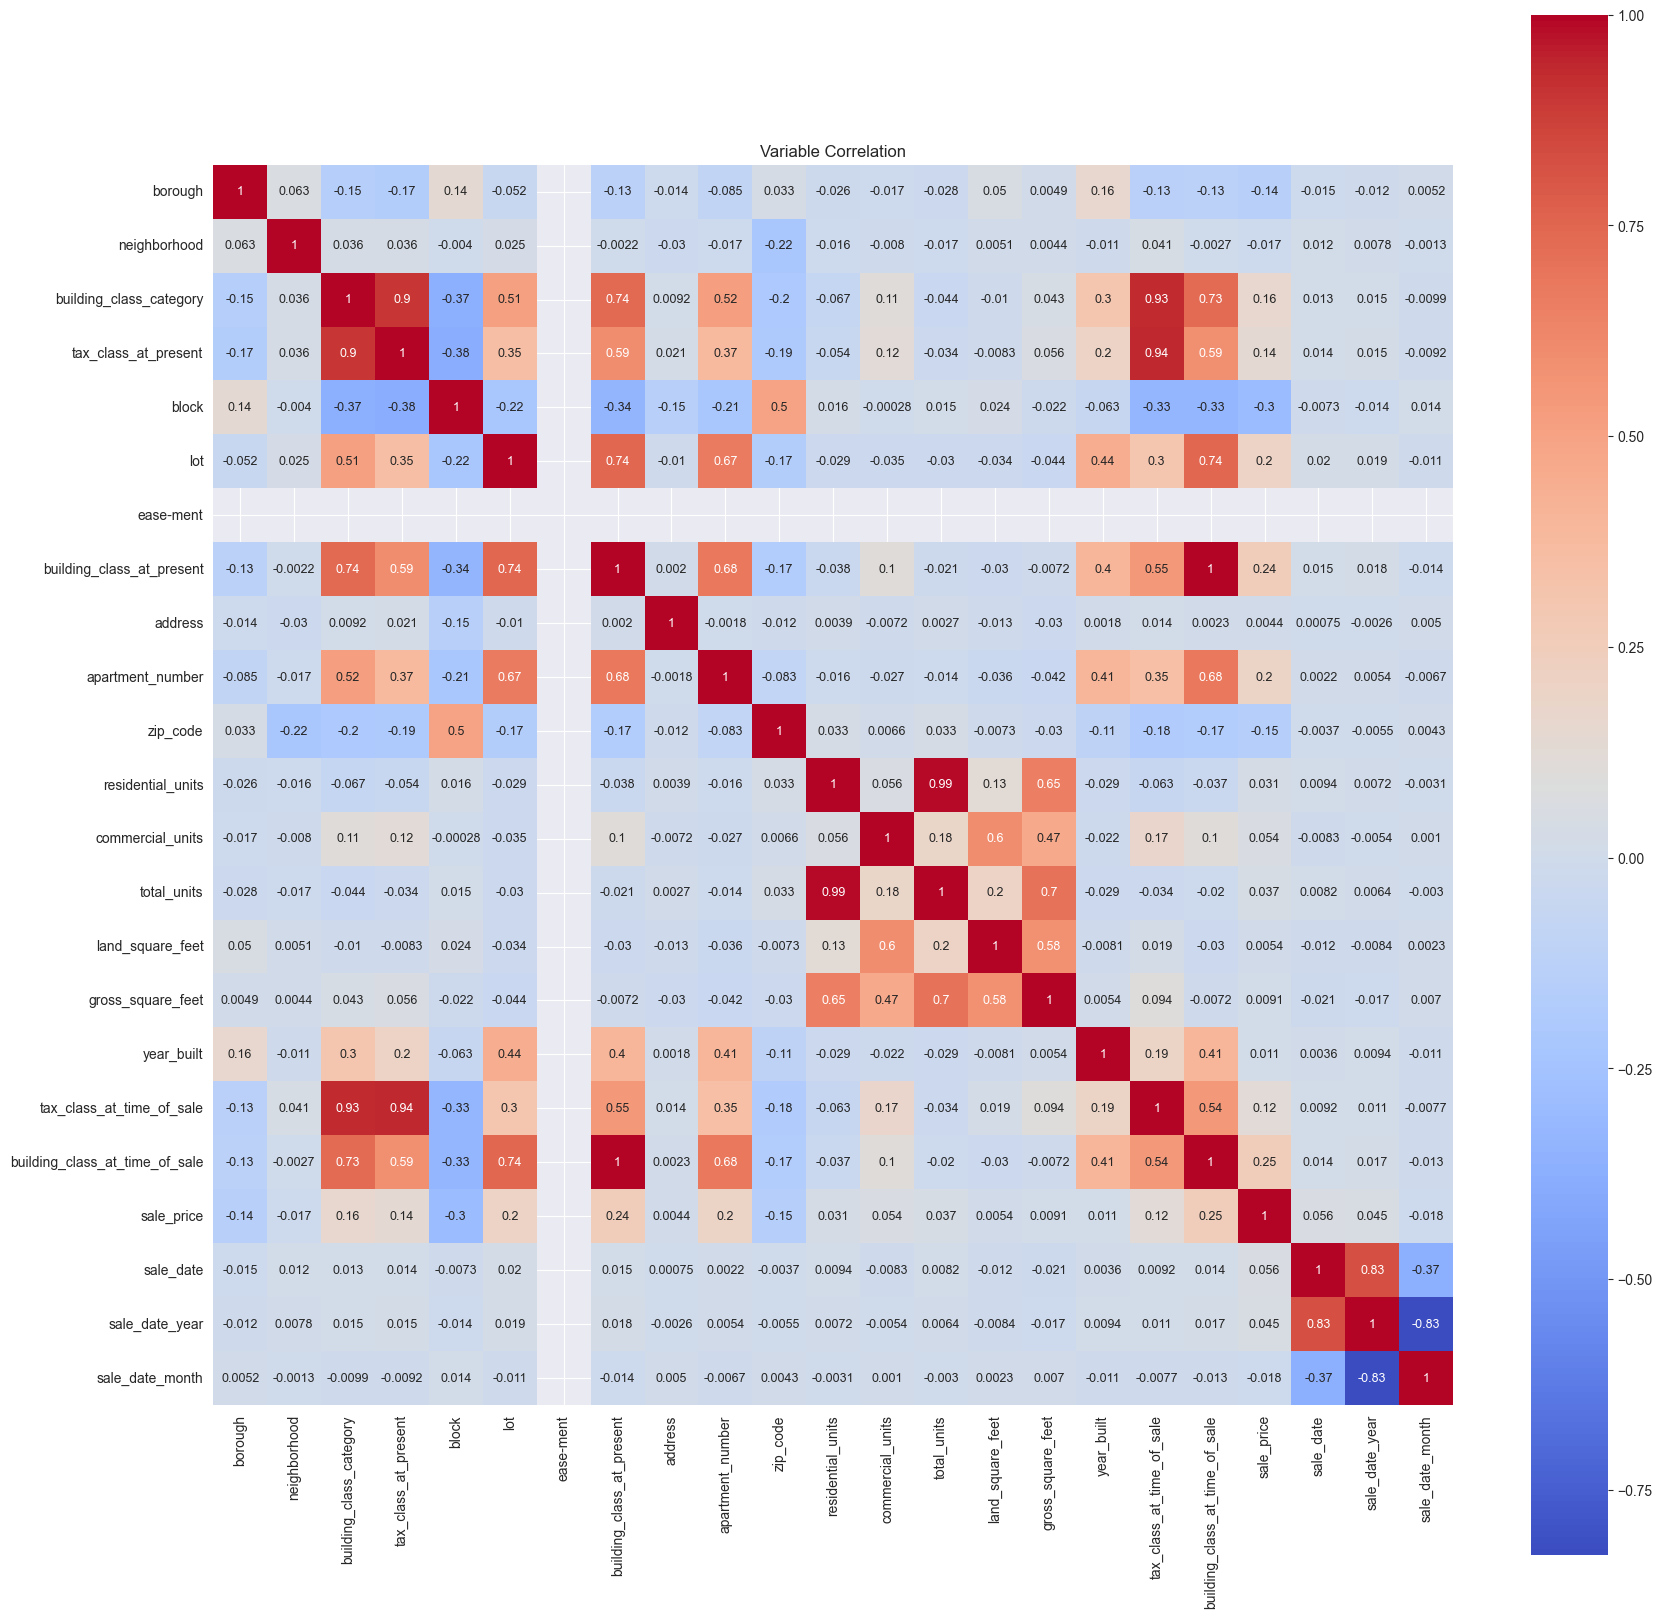

In [347]:
new_housing_corr = new_housing.corr()
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(new_housing_corr, cmap='coolwarm', square=True, annot=True, annot_kws={"size": 9})
plt.title('Variable Correlation')

In [348]:
# List of columns to drop
columns_to_drop = ['ease-ment', 'address', 'apartment_number', 'zip_code']
new_housing.drop(columns=columns_to_drop, inplace=True)

C:\Users\tayla\AppData\Local\Temp\ipykernel_30396\4105028189.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_housing.drop(columns=columns_to_drop, inplace=True)


Text(0.5, 1.0, 'Variable Correlation')

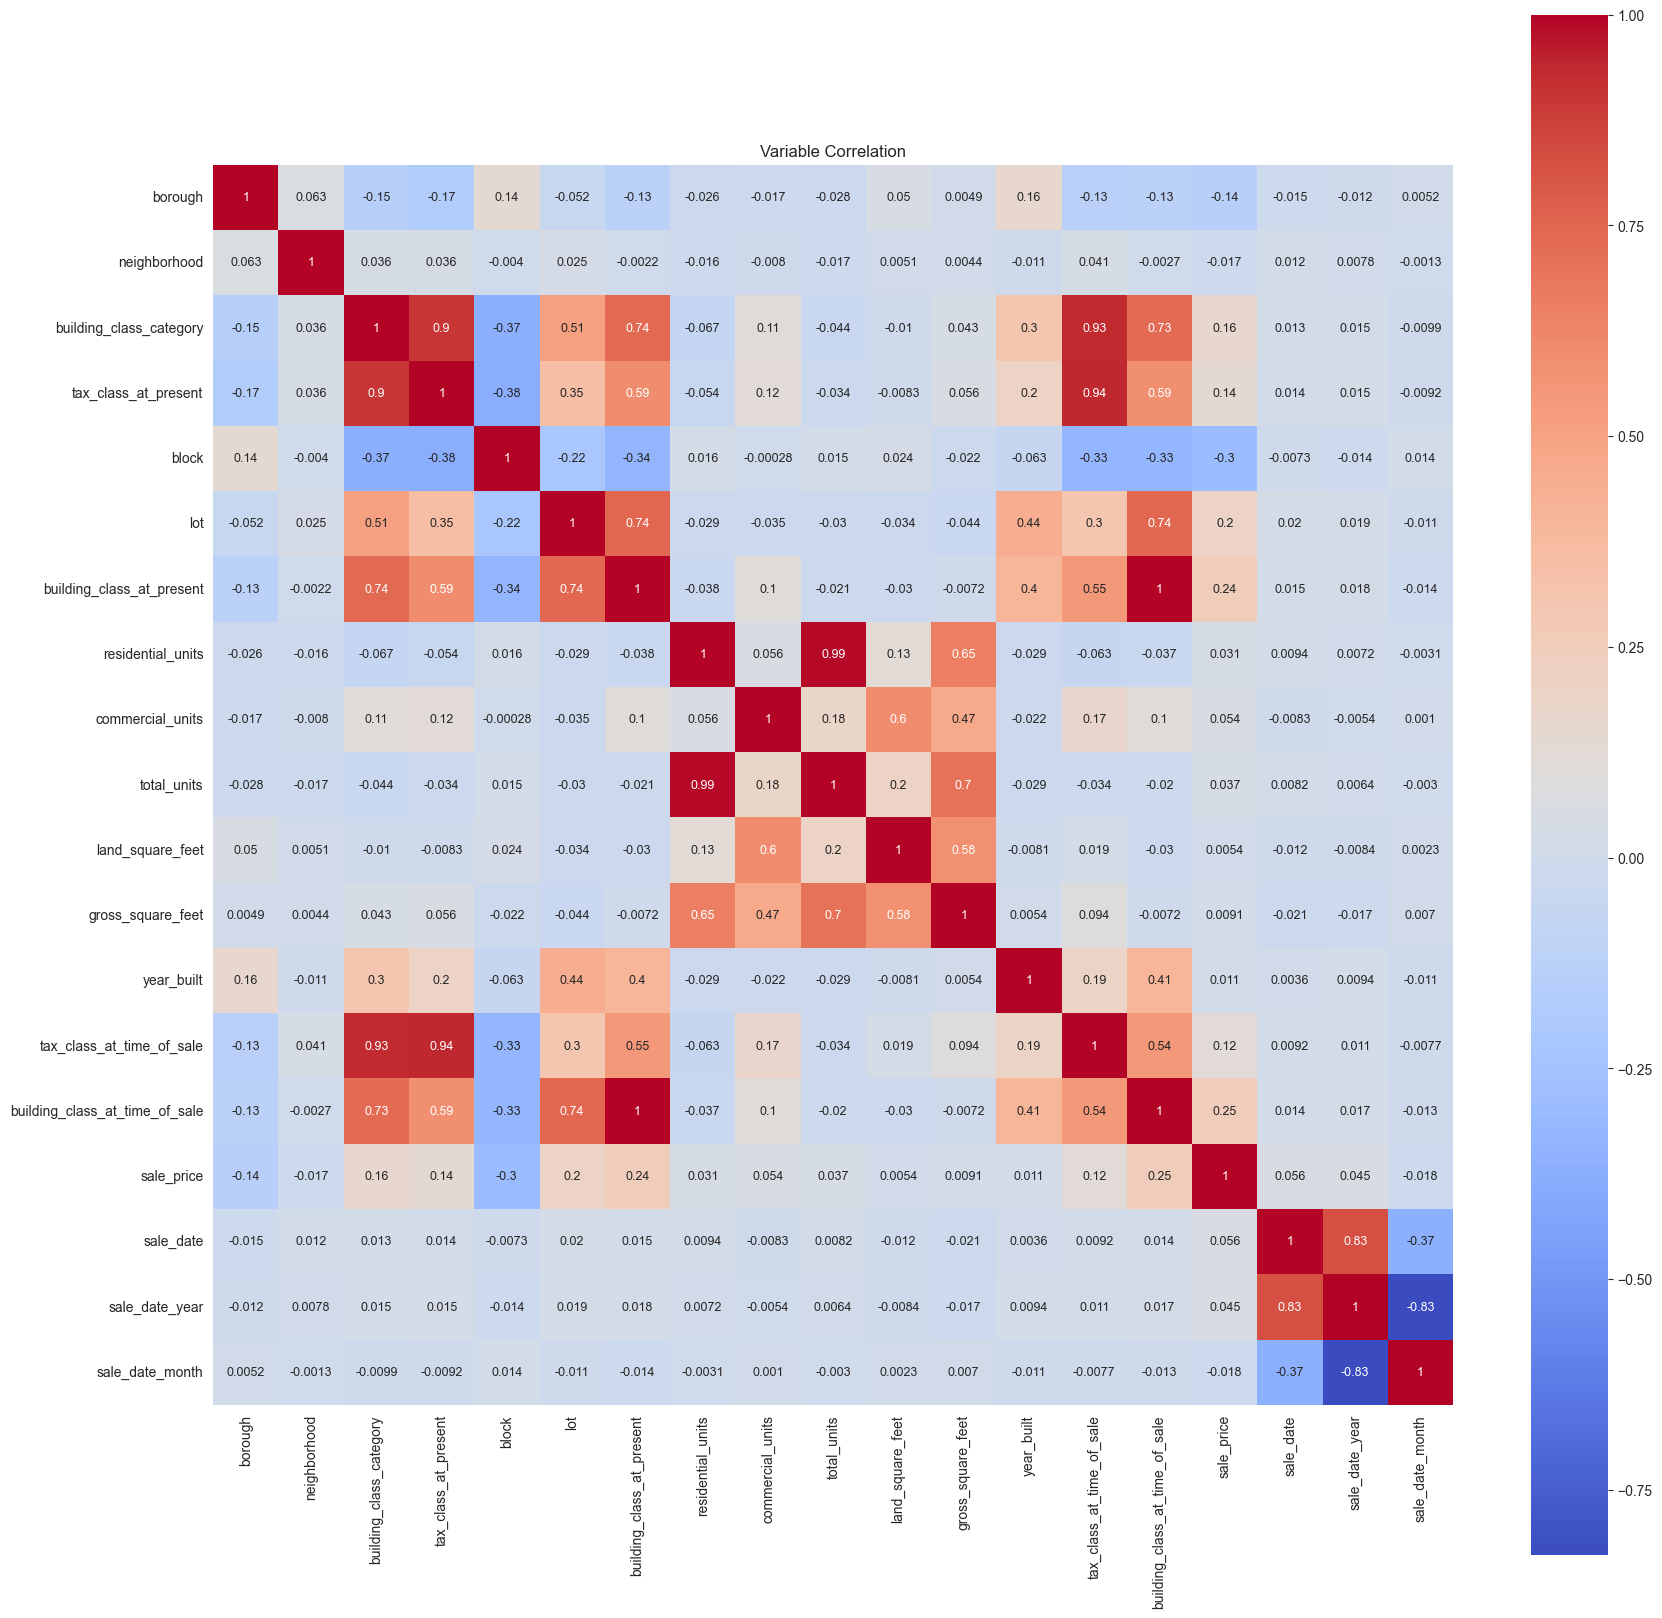

In [349]:
new_housing_corr = new_housing.corr()
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(new_housing_corr, cmap='coolwarm', square=True, annot=True, annot_kws={"size": 9})
plt.title('Variable Correlation')

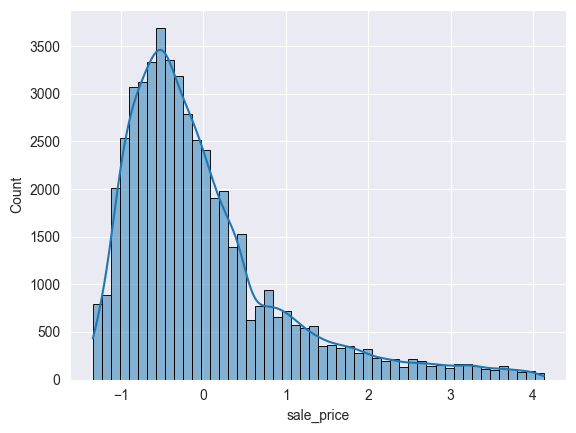

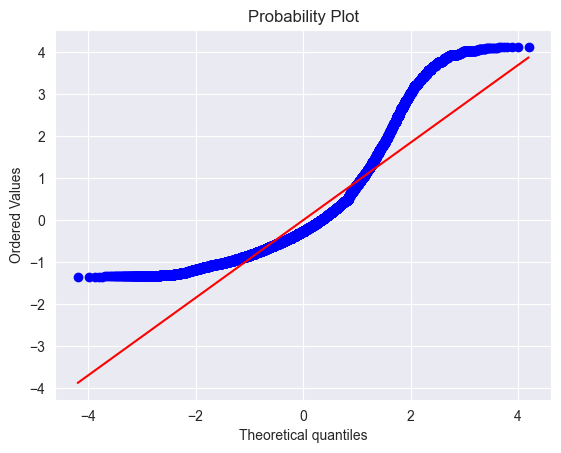

In [350]:
#histogram and normal probability plot
from scipy.stats import norm
from scipy import stats
sns.histplot(new_housing['sale_price'], bins=50,edgecolor = "k", kde=True)
fig = plt.figure()
res = stats.probplot(new_housing['sale_price'], plot=plt)

Far from linearity. Positive skewness.

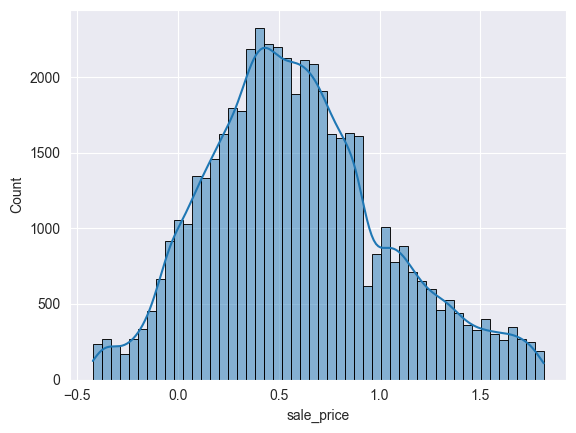

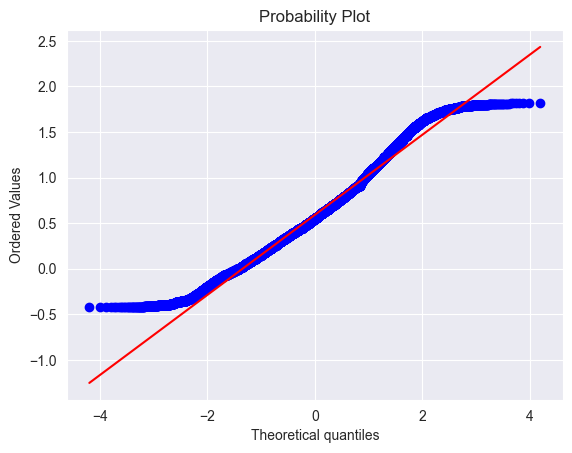

In [351]:
#applying log transformation

df_log = new_housing.copy()
df_log['sale_price'] = np.log1p(df_log['sale_price']+1)
sns.histplot(df_log['sale_price'], bins=50,edgecolor = "k", kde=True)
fig = plt.figure()
res = stats.probplot(df_log['sale_price'], plot=plt)